# Hosting Strands Agents with Amazon Bedrock models in Amazon Bedrock AgentCore Runtime

## Overview

In this tutorial we will learn how to host your existing agent, using Amazon Bedrock AgentCore Runtime. We will provide examples using Amazon Bedrock models and non-Bedrock models such as Azure OpenAI and Gemini. We will also showcase Observability through CloudWatch using AWS Opentelemetry Instrumentation and AgentCore Observability.


### Tutorial Details


| Information         | Details                                                                          |
|:--------------------|:---------------------------------------------------------------------------------|
| Tutorial type       | Conversational                                                                   |
| Agent type          | Single                                                                           |
| Agentic Framework   | Strands Agents                                                                   |
| LLM model           | Anthropic Claude Sonnet 4                                                        |
| Tutorial components | Hosting agent on AgentCore Runtime. Using Strands Agent and Amazon Bedrock Model |
| Tutorial vertical   | Cross-vertical                                                                   |
| Example complexity  | Easy                                                                             |
| SDK used            | Amazon BedrockAgentCore Python SDK and boto3                                     |

### Tutorial Architecture

In this tutorial we will describe how to deploy an existing agent to AgentCore runtime. 

For demonstration purposes, we will  use a Strands Agent using Amazon Bedrock models

In our example we will use a very simple agent with two tools: `get_weather` and `get_time`. 

<div style="text-align:left">
    <img src="images/architecture_runtime.png" width="50%"/>
</div>

### Tutorial Key Features

* Hosting Agents on Amazon Bedrock AgentCore Runtime
* Using Amazon Bedrock models
* Using Strands Agents
* Amazon CloudWatch GenAI Observability


## Prerequisites

To execute this tutorial you will need:
* Python 3.10+
* AWS credentials
* Amazon Bedrock AgentCore SDK
* Strands Agents
* Docker running
* Amazon CloudWatch Access
* Enable [transaction search](https://docs.aws.amazon.com/AmazonCloudWatch/latest/monitoring/Enable-TransactionSearch.html) on Amazon CloudWatch. 


In [ ]:
#!uv add -r requirements.txt --active

## Creating your agents and experimenting locally

Before we deploy our agents to AgentCore Runtime, let's develop and run them locally for experimentation purposes.

For production agentic applications we will need to decouple the agent creation process from the agent invocation one. With AgentCore Runtime, we will decorate the invocation part of our agent with the `@app.entrypoint` decorator and have it as the entry point for our runtime. Let's first look how each agent is developed during the experimentation phase.

The architecture here will look as following:

<div style="text-align:left">
    <img src="images/architecture_local.png" width="50%"/>
</div>

In [ ]:
%%writefile strands_claude.py
from strands import Agent, tool
from strands_tools import calculator # Import the calculator tool
import argparse
import json
from strands.models import BedrockModel

# Create a custom tool 
@tool
def weather():
    """ Get weather """ # Dummy implementation
    return "sunny"


model_id = "us.anthropic.claude-sonnet-4-20250514-v1:0"
model = BedrockModel(
    model_id=model_id,
)
agent = Agent(
    model=model,
    tools=[calculator, weather],
    system_prompt="You're a helpful assistant. You can do simple math calculation, and tell the weather."
)

def strands_agent_bedrock(payload):
    """
    Invoke the agent with a payload
    """
    user_input = payload.get("prompt")
    response = agent(user_input)
    return response.message['content'][0]['text']

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("payload", type=str)
    args = parser.parse_args()
    response = strands_agent_bedrock(json.loads(args.payload))
    print(response)

In [ ]:
!python strands_claude.py '{"prompt": "What is the weather now?"}'

## Preparing your agent for deployment on AgentCore Runtime

Let's now deploy our agents to AgentCore Runtime. To do so we need to:
* Import the Runtime App with `from bedrock_agentcore.runtime import BedrockAgentCoreApp`
* Initialize the App in our code with `app = BedrockAgentCoreApp()`
* Decorate the invocation function with the `@app.entrypoint` decorator
* Let AgentCoreRuntime control the running of the agent with `app.run()`

### Strands Agents with Amazon Bedrock model
Let's start with our Strands Agent using Amazon Bedrock model. All the others will work exactly the same.

In [ ]:
%%writefile strands_claude.py
from strands import Agent, tool
from strands_tools import calculator # Import the calculator tool
import argparse
import json
from bedrock_agentcore.runtime import BedrockAgentCoreApp
from strands.models import BedrockModel

app = BedrockAgentCoreApp()

# Create a custom tool 
@tool
def weather():
    """ Get weather """ # Dummy implementation
    return "sunny"


model_id = "us.anthropic.claude-sonnet-4-20250514-v1:0"
model = BedrockModel(
    model_id=model_id,
)
agent = Agent(
    model=model,
    tools=[calculator, weather],
    system_prompt="You're a helpful assistant. You can do simple math calculation, and tell the weather."
)

@app.entrypoint
def strands_agent_bedrock(payload):
    """
    Invoke the agent with a payload
    """
    user_input = payload.get("prompt")
    print("User input:", user_input)
    response = agent(user_input)
    return response.message['content'][0]['text']

if __name__ == "__main__":
    app.run()

## What happens behind the scenes?

When you use `BedrockAgentCoreApp`, it automatically:

* Creates an HTTP server that listens on the port 8080
* Implements the required `/invocations` endpoint for processing the agent's requirements
* Implements the `/ping` endpoint for health checks (very important for asynchronous agents)
* Handles proper content types and response formats
* Manages error handling according to the AWS standards

## Deploying the agent to AgentCore Runtime

The `CreateAgentRuntime` operation supports comprehensive configuration options, letting you specify container images, environment variables and encryption settings. You can also configure protocol settings (HTTP, MCP) and authorization mechanisms to control how your clients communicate with the agent. 

**Note:** Operations best practice is to package code as container and push to ECR using CI/CD pipelines and IaC

In this tutorial can will the Amazon Bedrock AgentCode Python SDK to easily package your artifacts and deploy them to AgentCore runtime.

### Creating runtime role

Before starting, let's create an IAM role for our AgentCore Runtime. We will do so using the utils function pre-developed for you.

In [ ]:
import sys
import os

# Get the current notebook's directory
current_dir = os.path.dirname(os.path.abspath('__file__' if '__file__' in globals() else '.'))

# Navigate up to the utils.py location
utils_dir = os.path.join(current_dir, '..')
utils_dir = os.path.abspath(utils_dir)

# Add to sys.path
sys.path.insert(0, utils_dir)

from utils import create_agentcore_role

agent_name="strands_claude"
agentcore_iam_role = create_agentcore_role(agent_name=agent_name)

### Configure AgentCore Runtime deployment

Next we will use our starter toolkit to configure the AgentCore Runtime deployment with an entrypoint, the execution role we just created and a requirements file. We will also configure the starter kit to auto create the Amazon ECR repository on launch.

During the configure step, your docker file will be generated based on your application code. 

Please note that when using the `bedrock_agentcore_starter_toolkit` to configure your agent, it takes care of the opentelemetry instrumentation. 

When configuring for containerized environment (such as docker) add the following command, an example is given below:

`CMD ["opentelemetry-instrument", "python", "runtime_agent_main.py"]`


<div style="text-align:left">
    <img src="images/configure.png" width="40%"/>
</div>

In [ ]:
from bedrock_agentcore_starter_toolkit import Runtime
from boto3.session import Session
boto_session = Session()
region = boto_session.region_name
region

agentcore_runtime = Runtime()

response = agentcore_runtime.configure(
    entrypoint="strands_claude.py",
    execution_role=agentcore_iam_role['Role']['Arn'],
    auto_create_ecr=True,
    requirements_file="requirements.txt",
    region=region,
    agent_name=agent_name+"2"
)
response

### Launching agent to AgentCore Runtime

Now that we've got a docker file, let's launch the agent to the AgentCore Runtime. This will create the Amazon ECR repository and the AgentCore Runtime

<div style="text-align:left">
    <img src="images/launch.png" width="75%"/>
</div>

In [ ]:
launch_result = agentcore_runtime.launch()
launch_result

### Checking for the AgentCore Runtime Status
Now that we've deployed the AgentCore Runtime, let's check for it's deployment status

In [ ]:
status_response = agentcore_runtime.status()
status = status_response.endpoint['status']
end_status = ['READY', 'CREATE_FAILED', 'DELETE_FAILED', 'UPDATE_FAILED']
while status not in end_status:
    time.sleep(10)
    status_response = agentcore_runtime.status()
    status = status_response.endpoint['status']
    print(status)
status

### Invoking AgentCore Runtime

Finally, we can invoke our AgentCore Runtime with a payload

<div style="text-align:left">
    <img src="images/invoke.png" width=75%"/>
</div>

In [ ]:
invoke_response = agentcore_runtime.invoke({"prompt": "How is the weather now?"})
invoke_response

### Processing invocation results

We can now process our invocation results to include it in an application

In [ ]:
from IPython.display import Markdown, display
import json
response_text = json.loads(invoke_response['response'][0].decode("utf-8"))
display(Markdown(response_text))

### Invoking AgentCore Runtime with boto3

Now that your AgentCore Runtime was created you can invoke it with any AWS SDK. For instance, you can use the boto3 `invoke_agent_runtime` method for it.

In [ ]:
import boto3
agent_arn = launch_result.agent_arn
agentcore_client = boto3.client(
    'bedrock-agentcore',
    region_name=region
)

boto3_response = agentcore_client.invoke_agent_runtime(
    agentRuntimeArn=agent_arn,
    qualifier="DEFAULT",
    payload=json.dumps({"prompt": "What is 2+2?"})
)
if "text/event-stream" in boto3_response.get("contentType", ""):
    content = []
    for line in boto3_response["response"].iter_lines(chunk_size=1):
        if line:
            line = line.decode("utf-8")
            if line.startswith("data: "):
                line = line[6:]
                logger.info(line)
                content.append(line)
    display(Markdown("\n".join(content)))
else:
    try:
        events = []
        for event in boto3_response.get("response", []):
            events.append(event)
    except Exception as e:
        events = [f"Error reading EventStream: {e}"]
    display(Markdown(json.loads(events[0].decode("utf-8"))))

### AgentCore Observability on Amazon CloudWatch 

To summarize, please follow the below steps to enable observability from AgentCore runtime hosted agents : 

- Enable Transaction Search on Amazon CloudWatch 
- The runtime agent is instrumented using opentelemtry command : `opentelemetry-instrument python any_runtime_agent.py`
- The requirements.txt file contains `aws-opentelemetry-distro` listed while deploying the agent on Bedrock Agentcore Runtime.


## Bedrock AgentCore Overview on GenAI Observability dashboard 

You are able to view all your Agents that have observability in them and filter the data based on time frames, some examples are provided below :

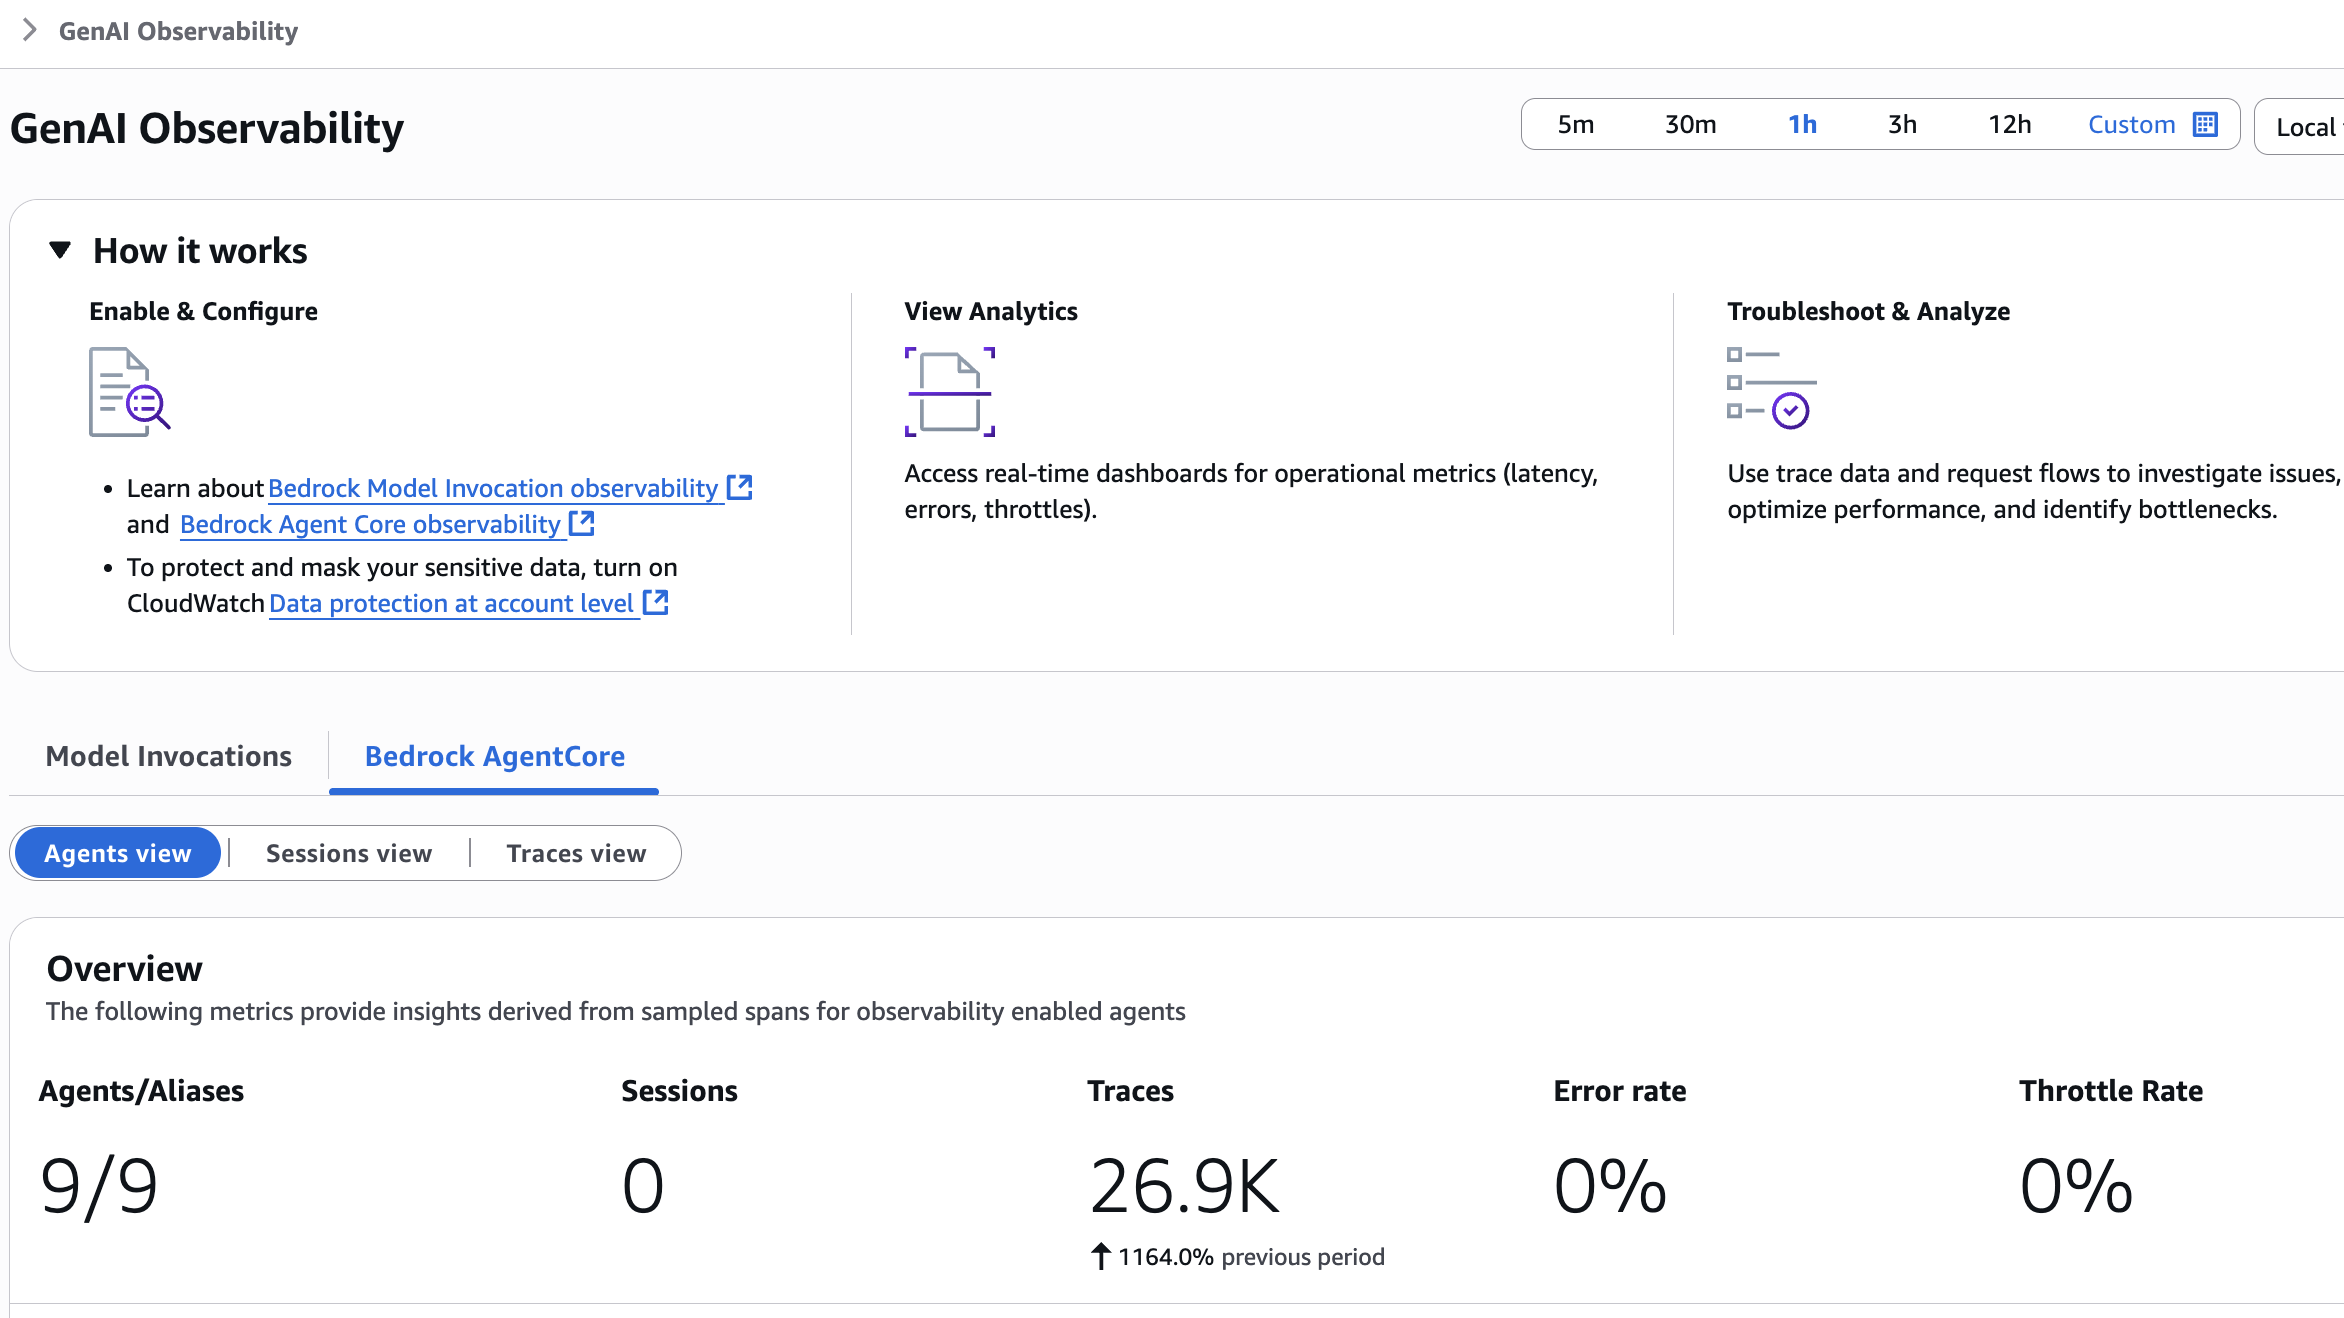

In the main dashboard you are able to view runtime metrics accross all agents as shown below: 

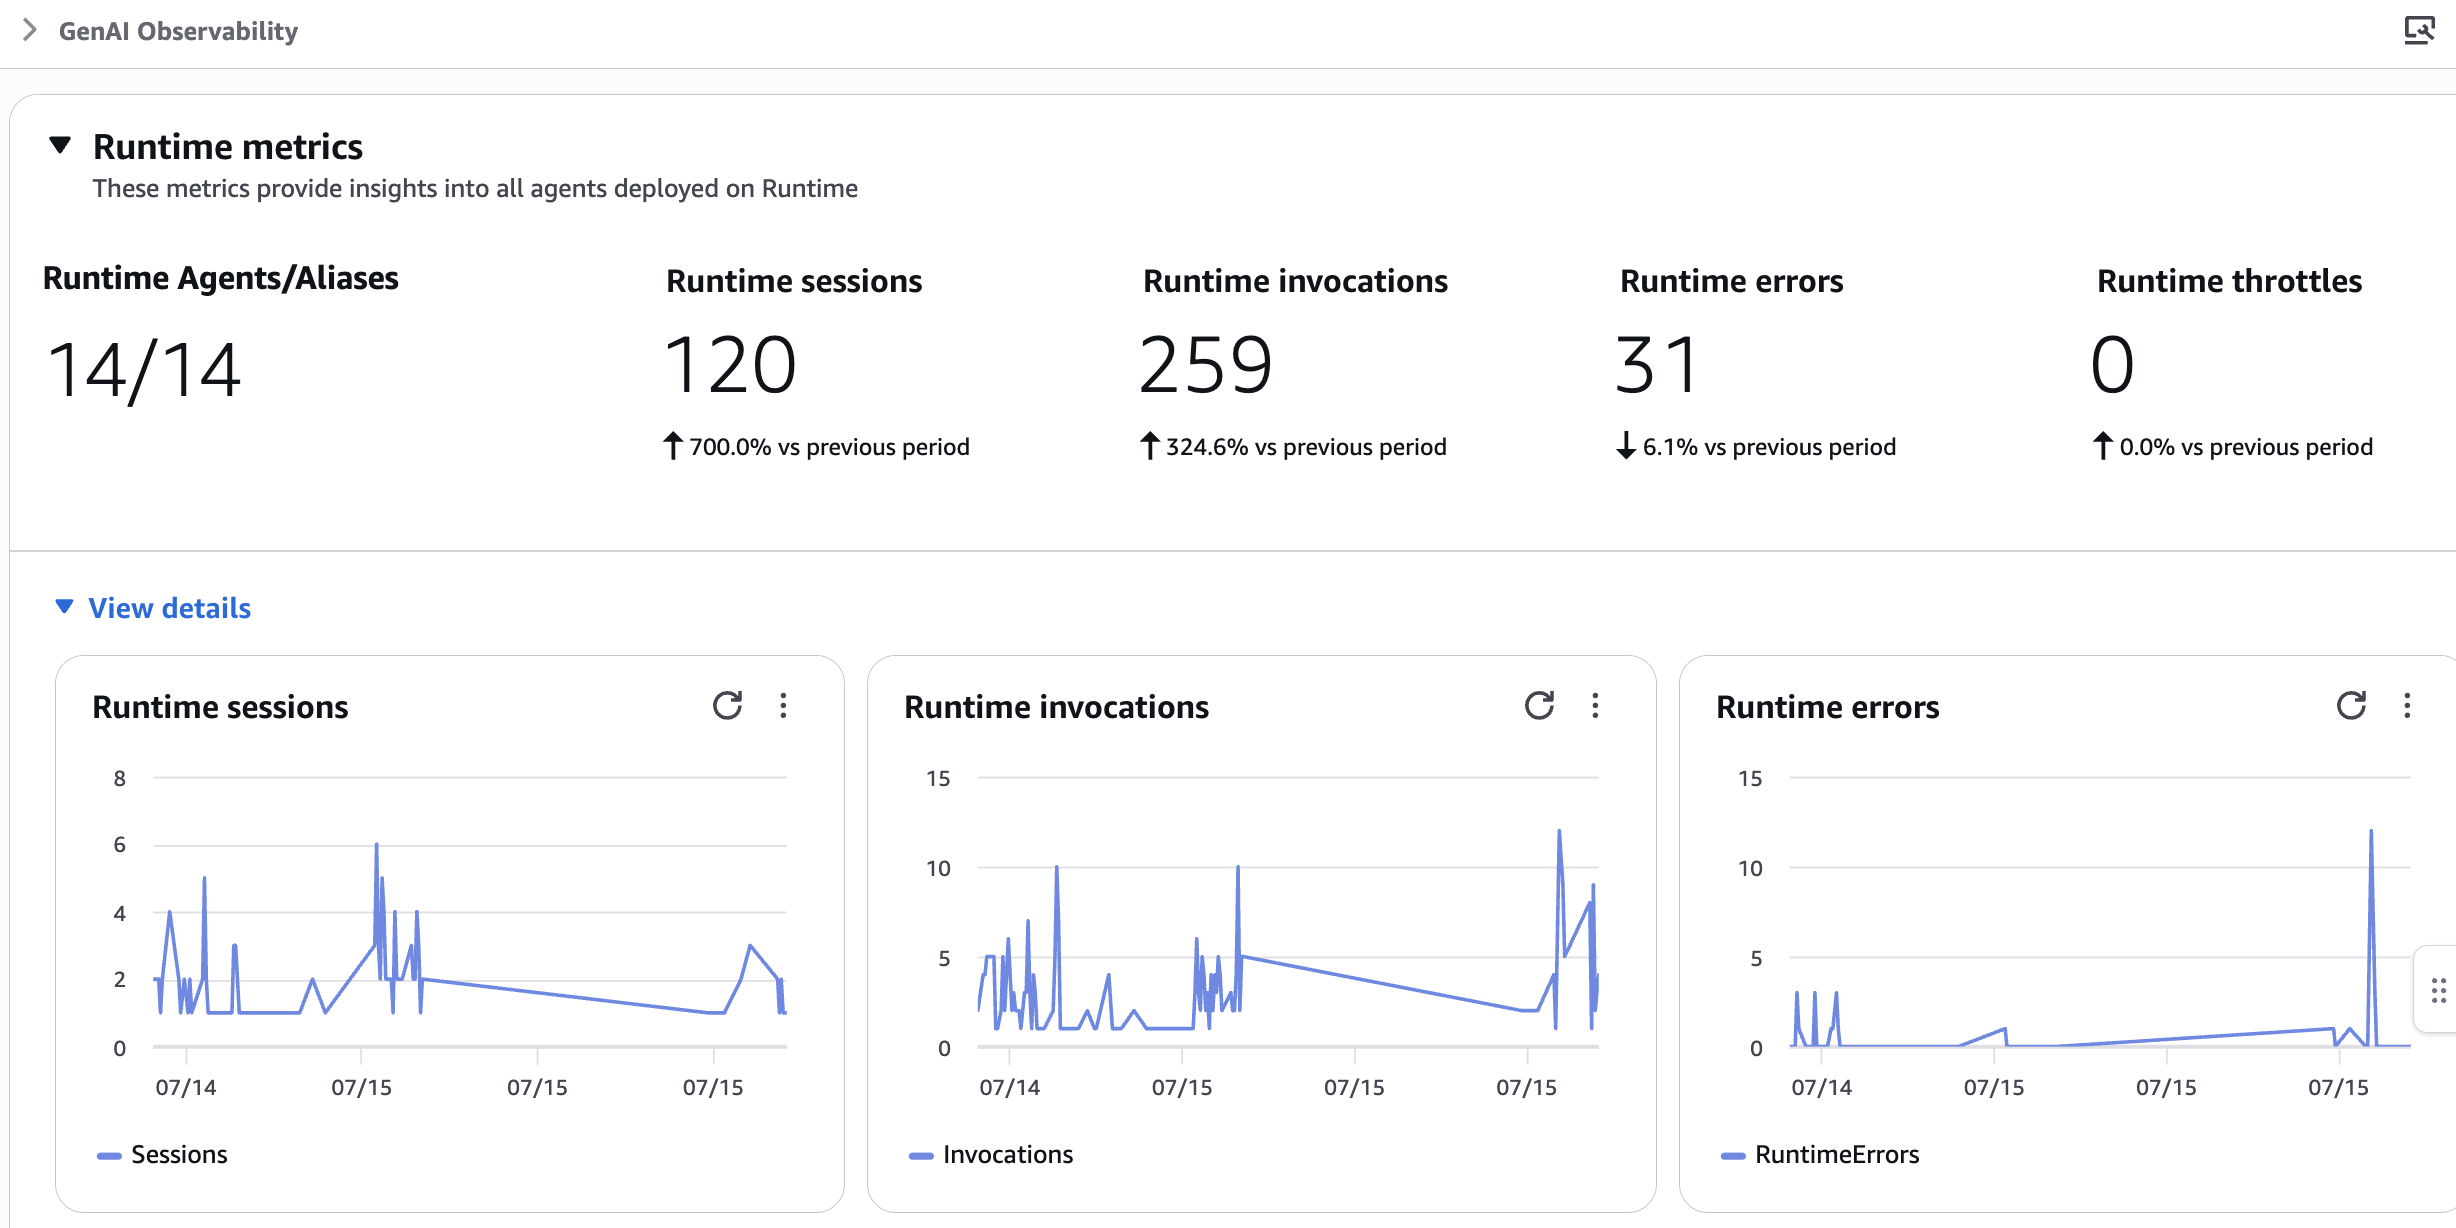

Now, if you click on the agent you just deployed you will be taken to a dashboard for the runtime metrics specific to this agent, you can also filter the data by a custom time frame: 

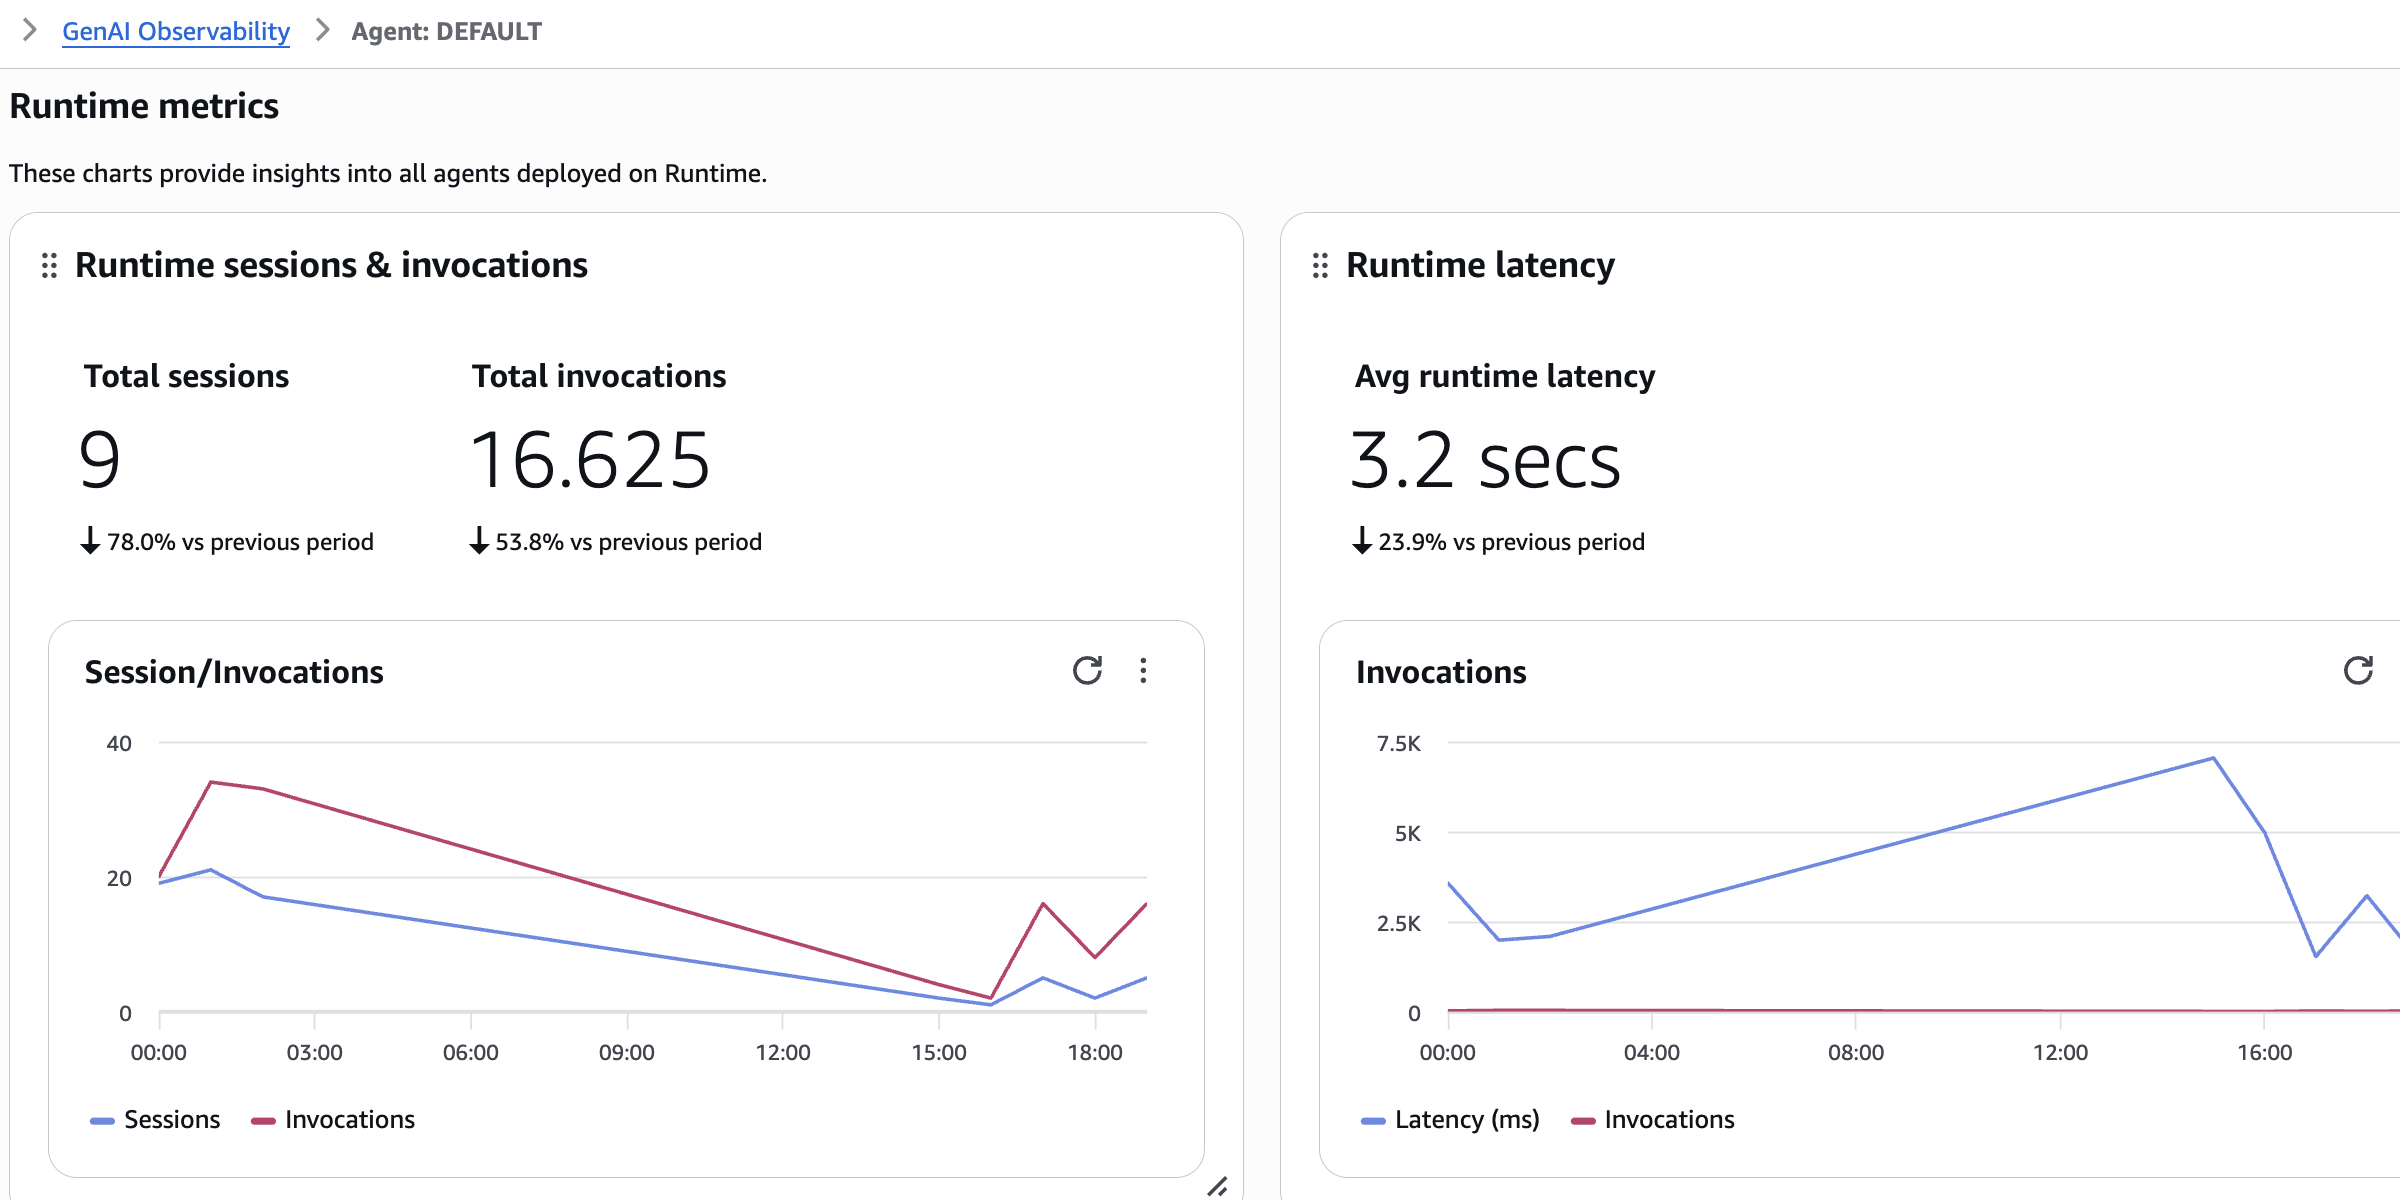

In the Sessions View tab, you can navigate to all the sessions associated with this agent: 

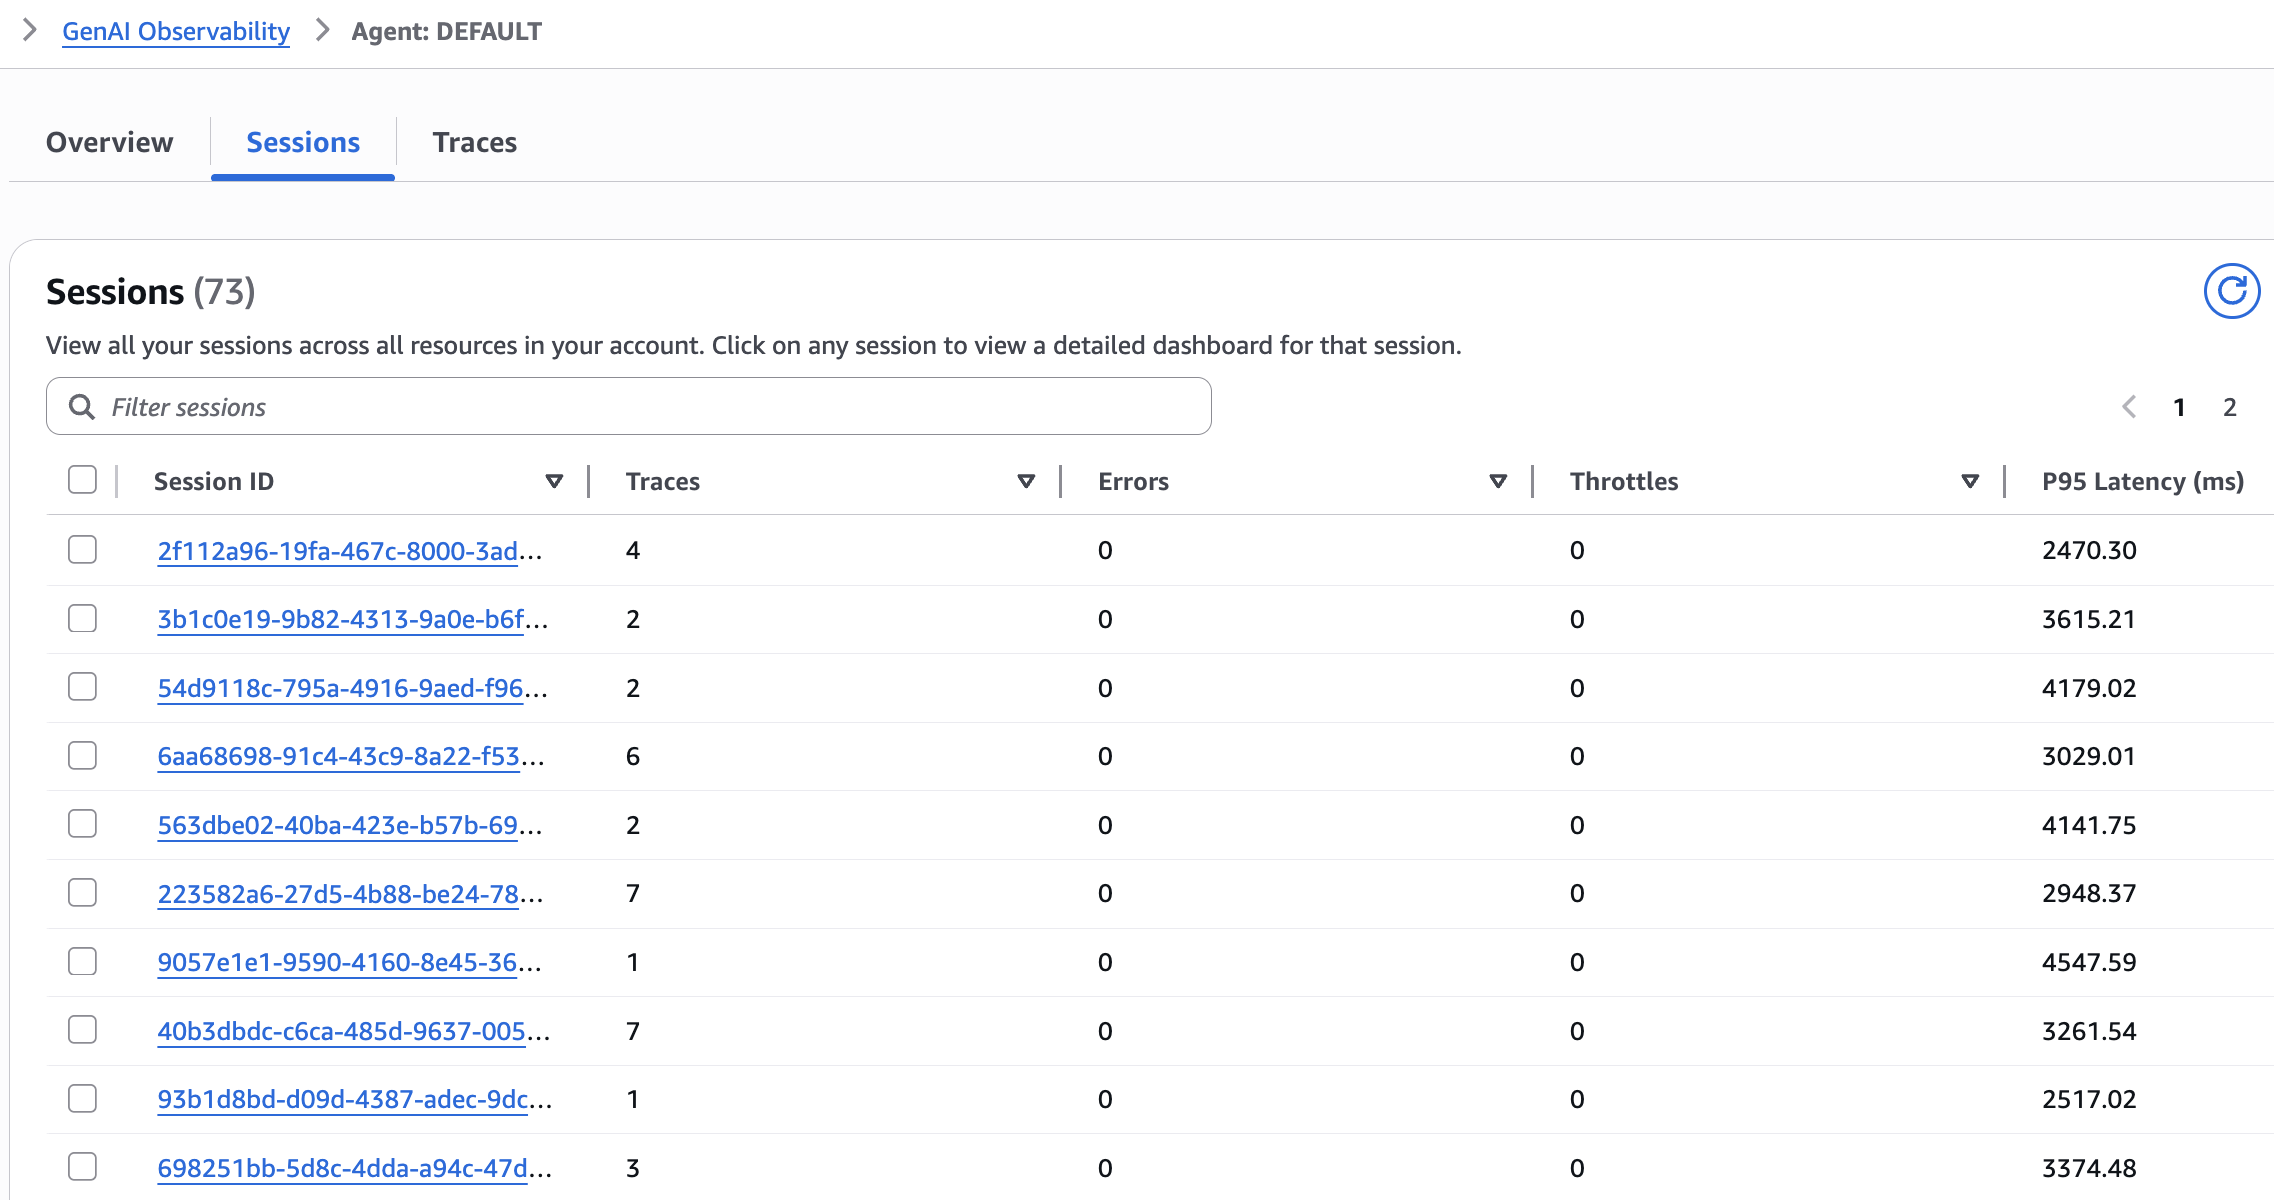

In the Trace View tab, you can look into the traces and span information for this agent on runtime. 

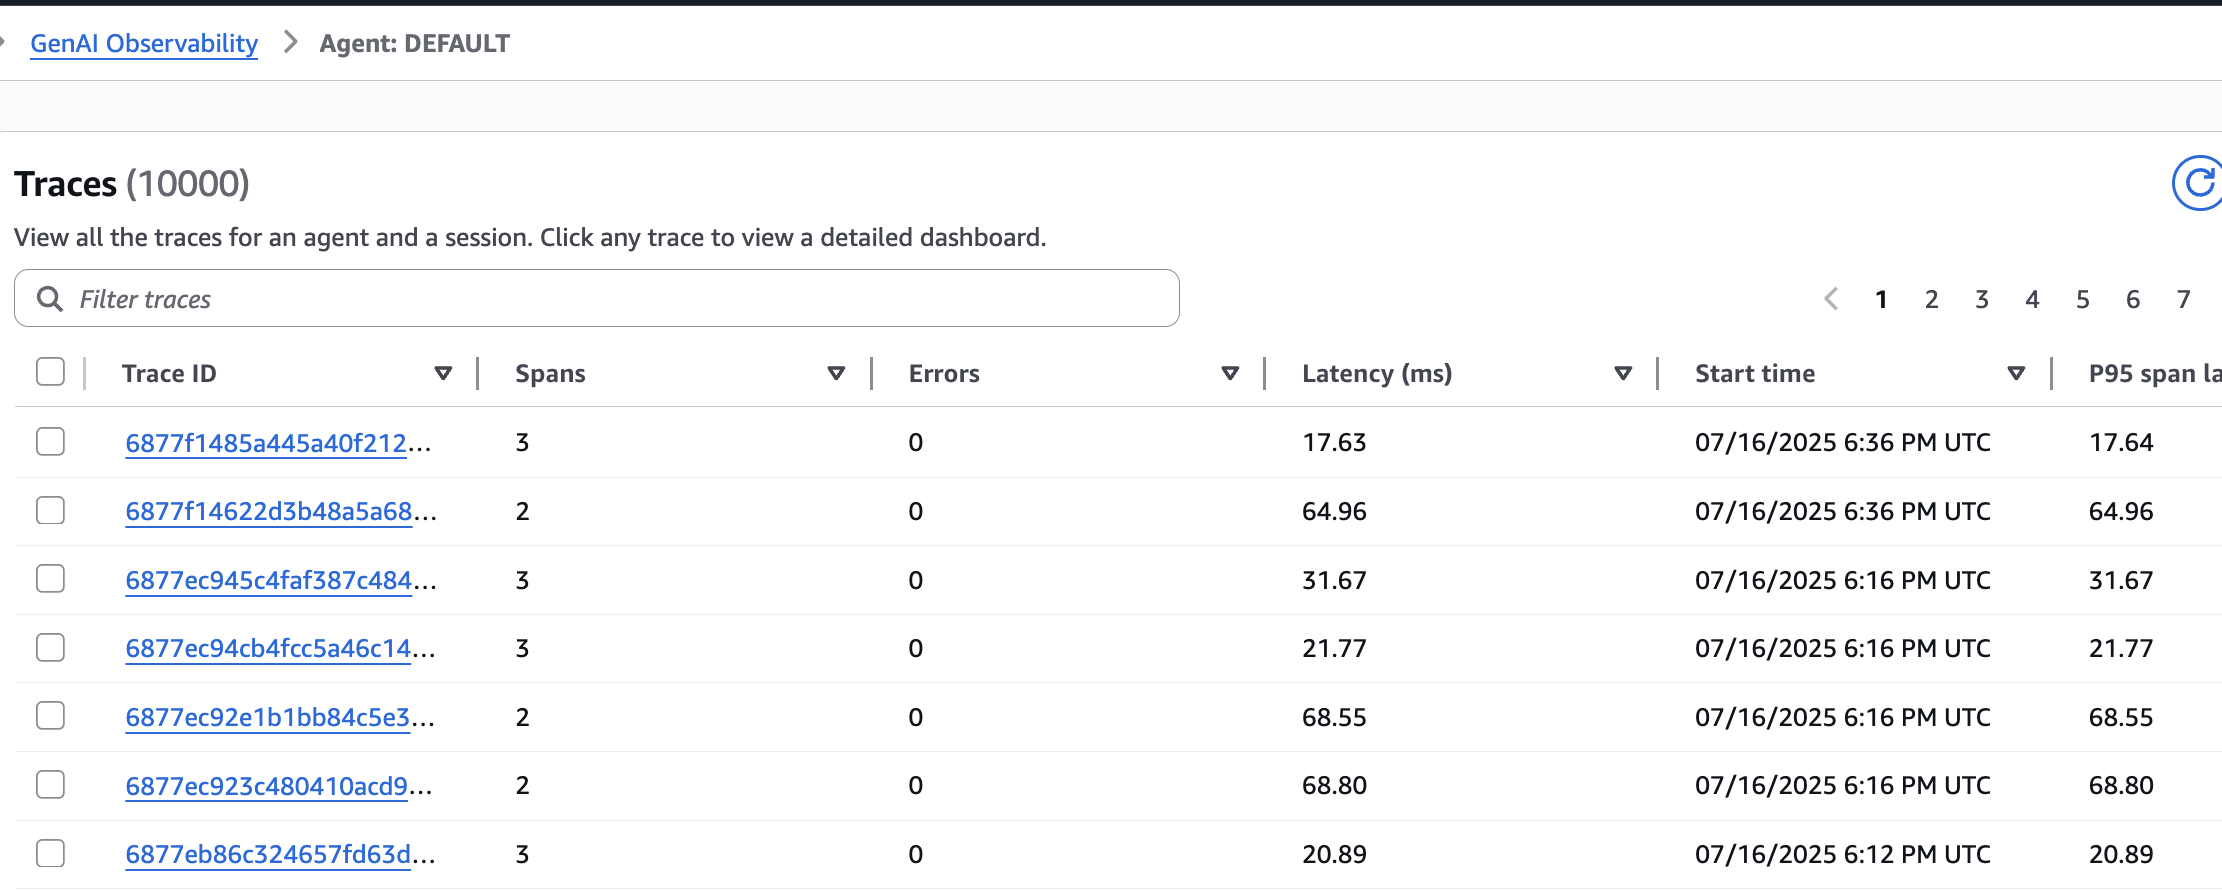


Please click through the various features of GenAI observability dashboard to get more detailed information on traces.


## Cleanup (Optional)

Let's now clean up the AgentCore Runtime created

In [ ]:
launch_result

In [ ]:
agentcore_control_client = boto3.client(
    'bedrock-agentcore-control',
    region_name=region
)
ecr_client = boto3.client(
    'ecr',
    region_name=region
    
)

iam_client = boto3.client('iam')

runtime_delete_response = agentcore_control_client.delete_agent_runtime(
    agentRuntimeId=launch_result.agent_id,
    
)

response = ecr_client.delete_repository(
    repositoryName=launch_result.ecr_uri.split('/')[1],
    force=True
)

policies = iam_client.list_role_policies(
    RoleName=agentcore_iam_role['Role']['RoleName'],
    MaxItems=100
)

for policy_name in policies['PolicyNames']:
    iam_client.delete_role_policy(
        RoleName=agentcore_iam_role['Role']['RoleName'],
        PolicyName=policy_name
    )
iam_response = iam_client.delete_role(
    RoleName=agentcore_iam_role['Role']['RoleName']
)

# Congratulations!